In [1]:
"""
Steven Yen, 2Q18
Dog Breed Identification Project (Kaggle Challenge).
Trains a model to identify dog breed based on a picture of the dog.
"""

import matplotlib.image as img
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, MaxPooling2D,GlobalAveragePooling2D, Dropout
import time
import random
from keras.callbacks import ModelCheckpoint


c:\users\events2q18win\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
The following constants and file paths are used for parsing the 10222 labeled images
from kaggle. The images will be import and converted into the dimension image_height by image_width (specified below).
The labels will be imported from the labels.csv file. 
"""

####CONSTANTS####

#file path containing all the images in training set (must end in path divider \\ for windows or / for linux)
fPath = "G:\\zSteven2Q18\\MachineLearningStuff\\DogProj\\train_data\\orig\\train\\train\\"
#file path containing the csv file with labels (must end in path divier)
labelsFilePath = "C:\\eventsNewTower2q18_mass\\dogBreedIdProjData\\data\\labels-csv\\" 
labelsFileName = "labels.csv" #file name of the csv containing the label (breed) for each picture

#file path containing all the images in unlabeled training set (end in path divider)
unlabledTestsetFPath = "G:\\zSteven2Q18\\MachineLearningStuff\\DogProj\\test_data\\kaggle_testset\\"
#Path and name of the sample_submission.csv file from kaggle to read in image list
sampleSubmitFilePathAndName = r"C:\eventsNewTower2q18_mass\dogBreedIdProjData\sample_submission.csv"

#image dimensions
#dimension to import the image as (images are of variable sizes)
image_height = 100
image_width = 100

#this is for parsing the 10222 labeled images if we want to do our own validation (8177-2045 for 80-20)
trainSize = 8177 #number of data points to use for training (will take the specified number of lines starting from top)
testSize = 2045 #number of data points to use for testing (will take specifeid number of lines starting at index=trainSize)

#model common descripter for saving files
filenameDesc = "Dilated-CNN-DataAug-Rglzr" #no seperator


In [3]:
"""
this part loads the labels.csv file in as a dictionary of form {filename : dog breed}
"""

labelsfiles = open(labelsFilePath+labelsFileName)
fnameToLabelMap = {} #construction dictionary where entries are of the form {"000bec180eb18c7604dcecc8fe0dba07": 'boston_bull'}

junk = labelsfiles.readline() #discard first line which is just column title
newLine = labelsfiles.readline()

while newLine:
    newLine = newLine.replace("\n","")
    tempArr = newLine.split(",")
    fnameToLabelMap[tempArr[0]] = tempArr[1]
    newLine = labelsfiles.readline()
    
labelsfiles.close() 

In [4]:
"""
Create mapping of dog breed to a label number 
Create mapping of label number to dog breed
"""

dictValList = fnameToLabelMap.values() #list of 10222 including values for all entries in dictionary
setOfDogBreeds = sorted(list(set(dictValList))) #set of all dog breeds, as a list of alphabetically sorted strings
dog_indices = dict((db,i) for i,db in enumerate(setOfDogBreeds)) #map from dog to indices
indices_dog = dict((i,db) for i,db in enumerate(setOfDogBreeds)) #map from indices to dog

In [5]:
"""
This block loads in the list of file names in the unlabeled test set from kaggle
The file names are loaded in the same order they appear in kaggle sample_submissions.csv file
"""

SampleCSVPathAndName = sampleSubmitFilePathAndName
SampleFile = open(SampleCSVPathAndName)
TestSetFNameList =[]

junk = SampleFile.readline() #throw column title away
SampleLine = SampleFile.readline()

while SampleLine:
    TestSetFNameList.append(SampleLine.split(",")[0])
    SampleLine = SampleFile.readline()

SampleFile.close()

In [6]:
"""
This block contains helper methods
"""

def checkAccuracy(pred_y, gt_y):
    """pred_y is the prediction output, gt_y is the correct labels"""
    correctCT = 0 #count of correct predictions
    for i in range(len(pred_y)):
        predictedCharIdx = np.argmax(pred_y[i]) #next character predicted (index of True/1 in one-hot arr)
        actualCharIdx = gt_y[i].tolist().index(1) #actual next character (indexs of True/1 in one-hot arr)
        if predictedCharIdx==actualCharIdx:
            correctCT+=1
    print("Number of samples the prediction was applied to:",len(pred_y))
    print("Number of samples for which the model correctly predicted the breed:",correctCT)
    print("Prediction Accuracy:", correctCT/len(pred_y))
    
def getValueAfterStr(containingStr,precedingStr):
    """
    Helper function use by printGraphsFromOutput() function below 
    """
    return float(containingStr[containingStr.find(precedingStr)+int(len(precedingStr)):containingStr.find(precedingStr)+int(len(precedingStr))+6])

def printGraphsFromOutput(nameOfFileWithPrintOut,plotTitleDesc):
    """
    Prints the training curves (training loss and val_loss) (training acc and val_acc)
    Also prints the statistics such as the lowest val_loss and val_acc and epoch #
    Copy paste printout from traing each epochs into a text file
    param nameOfFileWithPrintOouf = name of text file with the printout.
    e.g. at the end add one cell then after training: create text file in same folder andcall this fun
    TODO: update the keyword headers use to search: trainlossH, trainaccH, vallossH, valaccH
    """
    file1 = open(nameOfFileWithPrintOut,'r')
    newline = file1.readline()
    newline = file1.readline()
    #prefix
    trainlossH = ' loss: '
    trainaccH = ' categorical_accuracy: '
    vallossH = ' val_loss: '
    valaccH = ' val_categorical_accuracy: '

    trainLossList = []
    trainAccList = []
    valLossList = []
    valAccList = []

    trainLossList.append(getValueAfterStr(newline,trainlossH))
    trainAccList.append(getValueAfterStr(newline,trainaccH))
    valLossList.append(getValueAfterStr(newline,vallossH))
    valAccList.append(getValueAfterStr(newline,valaccH))


    newline = file1.readline()

    while newline:
        if newline.startswith('Epoch'):
            newline = file1.readline()
            continue
        trainLossList.append(getValueAfterStr(newline,trainlossH))
        trainAccList.append(getValueAfterStr(newline,trainaccH))
        valLossList.append(getValueAfterStr(newline,vallossH))
        valAccList.append(getValueAfterStr(newline,valaccH))
        newline = file1.readline()

    file1.close()
    epochList = list(range(1,int(len(valAccList))+1))
    
    trainLossList = np.array(trainLossList)
    trainAccList = np.array(trainAccList)
    valLossList = np.array(valLossList)
    valAccList = np.array(valAccList)
    epochList = np.array(epochList)
    
    plt.figure(1)
    plt.plot(epochList,trainLossList,c='b', label='train_loss')
    plt.plot(epochList,valLossList,c='r', label='val_loss')
    plt.title('Training Curve for '+plotTitleDesc)
    plt.xlabel('epoch no.')
    plt.ylabel("loss")
    plt.legend(loc='best', shadow=True)
    
    plt.figure(2)
    plt.plot(epochList,trainAccList,c='b', label='train_acc')
    plt.plot(epochList,valAccList,c='r', label='val_acc')
    plt.title('Training Curve for '+plotTitleDesc)
    plt.xlabel('epoch no.')
    plt.ylabel("accuracy")
    plt.legend(loc='best', shadow=True)
    
    #print statistics
    #zero-indexed position, the index is one less than the epoch
    idxWithMinValLoss = np.argmin(valLossList)
    idxWithMaxValAcc = np.argmax(valAccList)
    
    print("The min val_loss was at epoch: ",str(idxWithMinValLoss+1)
          ,", val_loss=",valLossList[idxWithMinValLoss]
          ,", val_acc=",valAccList[idxWithMinValLoss])
    
    print("The max val_acc was at epoch: ",str(idxWithMaxValAcc+1)
         ,", val_loss=",valLossList[idxWithMaxValAcc]
         ,", val_acc=",valAccList[idxWithMaxValAcc])


In [7]:
"""
This block convert the labeled training dataset into form ready to be used by model
all_images will be an numpy array where each element is an HxWx3 array of arrays representing the image
all_labels will be a numpy array of arrays where each element is one-hot representation of the breed
"""

from keras.preprocessing import image                  

ct = 0 #when ct == dataToLad then break
all_images = [] #var to store all images as arrays
all_labels = [] #var to store all labels

for fname_i in fnameToLabelMap:
    imagePathAndName = fPath+fname_i+".jpg"
    image_i = image.load_img(imagePathAndName, target_size=(image_height,image_width))
    image_i = image.img_to_array(image_i)
    all_images.append(image_i)
    all_labels.append(dog_indices[fnameToLabelMap[fname_i]])
    
all_images = np.array(all_images) #convert all_images from list to numpy array
all_labels = np.array(all_labels) #convert all_labels from list to numpy array

all_images = all_images/255.0 #normalize
all_labels = np_utils.to_categorical(all_labels,120) #convert all_lables into 1-hot representation

In [8]:
#data parsed into all_images and all_labels and converted to right format for model.
all_images.shape

(10222, 100, 100, 3)

In [9]:
all_labels.shape

(10222, 120)

In [10]:
"""
Parse the labeled image into training and 'test' (validation) set for if we want to do our own validation
The model will not be trained on sample froms the test/validation set, which will only be used to 
calculate the metrics during training to monitor overfitting
"""

x_trainingInput = all_images[:trainSize] 
y_trainingLabel = all_labels[:trainSize]

#below are the validation sets used to calcualte "val_categorical_accuracy" and "val_loss"
#during training to monitor for overfitting
x_testingInput = all_images[trainSize:(trainSize+testSize)]  #more accurately called the validation set input.
y_testingLabel = all_labels[trainSize:(trainSize+testSize)] #more accurately called the validation set labels.
del all_images #delete all_images to free up RAM

In [11]:
x_trainingInput.shape

(8177, 100, 100, 3)

In [12]:
y_trainingLabel.shape

(8177, 120)

In [13]:
x_testingInput.shape

(2045, 100, 100, 3)

In [14]:
y_testingLabel.shape

(2045, 120)

In [15]:
"""Data Augmentation"""

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

inputGen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=30,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True
    )

inputGen.fit(x_trainingInput)

In [16]:
"""
Below is the code to construct and train the Model on the training set
Model based in part on that presented in the dilated 
convolution paper by F. Yu and V. Koltun arXiv:1511.07122 
Use small kernels with increasing dilation rate to increase field of view
without increasing number of parameters.
"""

from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = (image_height, image_width, 3)))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'valid', activation = 'relu', dilation_rate=2))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'valid', activation = 'relu', dilation_rate=4))
model.add(GlobalAveragePooling2D())
model.add(Dense(800, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 84, 84, 64)        18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               52000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
__________

In [17]:
"""
This block performs training with data augmentation
Uses check pointing to save the model weights when the validation loss is the lowest.
"""
chckptr_cb = ModelCheckpoint(filepath="DCNNWeights-{epoch:02d}-{val_loss:.4f}.hdf5",save_best_only=True)

model.fit_generator(inputGen.flow(x_trainingInput, y_trainingLabel, batch_size=32),
                    steps_per_epoch=len(x_trainingInput) / 32, epochs=750,
                    validation_data=(x_testingInput, y_testingLabel), verbose=1,
                    callbacks = [chckptr_cb])

Epoch 1/750
256/255 [==============================] - 46s 180ms/step - loss: 4.9055 - categorical_accuracy: 0.0113 - val_loss: 4.7879 - val_categorical_accuracy: 0.0108
Epoch 2/750
256/255 [==============================] - 43s 167ms/step - loss: 4.7804 - categorical_accuracy: 0.0118 - val_loss: 4.7903 - val_categorical_accuracy: 0.0117
Epoch 3/750
256/255 [==============================] - 43s 167ms/step - loss: 4.7786 - categorical_accuracy: 0.0122 - val_loss: 4.7905 - val_categorical_accuracy: 0.0117
Epoch 4/750
256/255 [==============================] - 42s 166ms/step - loss: 4.7779 - categorical_accuracy: 0.0104 - val_loss: 4.7926 - val_categorical_accuracy: 0.0142
Epoch 5/750
256/255 [==============================] - 42s 165ms/step - loss: 4.7677 - categorical_accuracy: 0.0145 - val_loss: 4.7598 - val_categorical_accuracy: 0.0137
Epoch 6/750
256/255 [==============================] - 42s 166ms/step - loss: 4.7366 - categorical_accuracy: 0.0148 - val_loss: 4.7546 - val_categoric

Epoch 49/750
256/255 [==============================] - 42s 165ms/step - loss: 4.3177 - categorical_accuracy: 0.0458 - val_loss: 4.3372 - val_categorical_accuracy: 0.0523
Epoch 50/750
256/255 [==============================] - 42s 164ms/step - loss: 4.3107 - categorical_accuracy: 0.0498 - val_loss: 4.3334 - val_categorical_accuracy: 0.0518
Epoch 51/750
256/255 [==============================] - 42s 165ms/step - loss: 4.3142 - categorical_accuracy: 0.0508 - val_loss: 4.3346 - val_categorical_accuracy: 0.0509
Epoch 52/750
256/255 [==============================] - 42s 165ms/step - loss: 4.2952 - categorical_accuracy: 0.0533 - val_loss: 4.3359 - val_categorical_accuracy: 0.0538
Epoch 53/750
256/255 [==============================] - 42s 165ms/step - loss: 4.2994 - categorical_accuracy: 0.0521 - val_loss: 4.3243 - val_categorical_accuracy: 0.0504
Epoch 54/750
256/255 [==============================] - 42s 165ms/step - loss: 4.2855 - categorical_accuracy: 0.0533 - val_loss: 4.3108 - val_cat

Epoch 97/750
256/255 [==============================] - 42s 164ms/step - loss: 3.9898 - categorical_accuracy: 0.0869 - val_loss: 4.0619 - val_categorical_accuracy: 0.0802
Epoch 98/750
256/255 [==============================] - 42s 164ms/step - loss: 3.9788 - categorical_accuracy: 0.0900 - val_loss: 4.1745 - val_categorical_accuracy: 0.0704
Epoch 99/750
256/255 [==============================] - 42s 164ms/step - loss: 3.9941 - categorical_accuracy: 0.0916 - val_loss: 4.0601 - val_categorical_accuracy: 0.0797
Epoch 100/750
256/255 [==============================] - 42s 164ms/step - loss: 3.9769 - categorical_accuracy: 0.0900 - val_loss: 4.0846 - val_categorical_accuracy: 0.0792
Epoch 101/750
256/255 [==============================] - 42s 164ms/step - loss: 3.9649 - categorical_accuracy: 0.0911 - val_loss: 4.0625 - val_categorical_accuracy: 0.0826
Epoch 102/750
256/255 [==============================] - 42s 164ms/step - loss: 3.9665 - categorical_accuracy: 0.0882 - val_loss: 4.0444 - val_

Epoch 145/750
256/255 [==============================] - 42s 165ms/step - loss: 3.7981 - categorical_accuracy: 0.1179 - val_loss: 3.9536 - val_categorical_accuracy: 0.1007
Epoch 146/750
256/255 [==============================] - 42s 165ms/step - loss: 3.8212 - categorical_accuracy: 0.1139 - val_loss: 3.9260 - val_categorical_accuracy: 0.1120
Epoch 147/750
256/255 [==============================] - 42s 165ms/step - loss: 3.7963 - categorical_accuracy: 0.1169 - val_loss: 3.9772 - val_categorical_accuracy: 0.1081
Epoch 148/750
256/255 [==============================] - 42s 165ms/step - loss: 3.7896 - categorical_accuracy: 0.1141 - val_loss: 4.0178 - val_categorical_accuracy: 0.1027
Epoch 149/750
256/255 [==============================] - 42s 165ms/step - loss: 3.7939 - categorical_accuracy: 0.1158 - val_loss: 4.0070 - val_categorical_accuracy: 0.1032
Epoch 150/750
256/255 [==============================] - 42s 164ms/step - loss: 3.7879 - categorical_accuracy: 0.1153 - val_loss: 3.9757 - v

256/255 [==============================] - 42s 164ms/step - loss: 3.6748 - categorical_accuracy: 0.1319 - val_loss: 3.9538 - val_categorical_accuracy: 0.1125
Epoch 193/750
256/255 [==============================] - 42s 165ms/step - loss: 3.6797 - categorical_accuracy: 0.1340 - val_loss: 3.9618 - val_categorical_accuracy: 0.1149
Epoch 194/750
256/255 [==============================] - 42s 164ms/step - loss: 3.6770 - categorical_accuracy: 0.1370 - val_loss: 3.9056 - val_categorical_accuracy: 0.1247
Epoch 195/750
256/255 [==============================] - 42s 164ms/step - loss: 3.6823 - categorical_accuracy: 0.1279 - val_loss: 3.8926 - val_categorical_accuracy: 0.1257
Epoch 196/750
256/255 [==============================] - 42s 164ms/step - loss: 3.6610 - categorical_accuracy: 0.1308 - val_loss: 3.9015 - val_categorical_accuracy: 0.1178
Epoch 197/750
256/255 [==============================] - 42s 165ms/step - loss: 3.6694 - categorical_accuracy: 0.1319 - val_loss: 3.9891 - val_categorical

Epoch 240/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5873 - categorical_accuracy: 0.1468 - val_loss: 4.0203 - val_categorical_accuracy: 0.1076
Epoch 241/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5879 - categorical_accuracy: 0.1462 - val_loss: 3.9069 - val_categorical_accuracy: 0.1213
Epoch 242/750
256/255 [==============================] - 42s 165ms/step - loss: 3.5788 - categorical_accuracy: 0.1469 - val_loss: 3.8933 - val_categorical_accuracy: 0.1267
Epoch 243/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5788 - categorical_accuracy: 0.1500 - val_loss: 3.9066 - val_categorical_accuracy: 0.1178
Epoch 244/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5964 - categorical_accuracy: 0.1519 - val_loss: 3.9141 - val_categorical_accuracy: 0.1257
Epoch 245/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5915 - categorical_accuracy: 0.1445 - val_loss: 3.8629 - v

256/255 [==============================] - 42s 164ms/step - loss: 3.5306 - categorical_accuracy: 0.1578 - val_loss: 3.8502 - val_categorical_accuracy: 0.1301
Epoch 288/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5258 - categorical_accuracy: 0.1612 - val_loss: 3.8753 - val_categorical_accuracy: 0.1247
Epoch 289/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5235 - categorical_accuracy: 0.1570 - val_loss: 3.8619 - val_categorical_accuracy: 0.1296
Epoch 290/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5316 - categorical_accuracy: 0.1567 - val_loss: 3.8782 - val_categorical_accuracy: 0.1257
Epoch 291/750
256/255 [==============================] - 42s 163ms/step - loss: 3.5167 - categorical_accuracy: 0.1557 - val_loss: 3.8541 - val_categorical_accuracy: 0.1301
Epoch 292/750
256/255 [==============================] - 42s 164ms/step - loss: 3.5205 - categorical_accuracy: 0.1595 - val_loss: 3.9384 - val_categorical

Epoch 335/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4551 - categorical_accuracy: 0.1644 - val_loss: 3.8295 - val_categorical_accuracy: 0.1369
Epoch 336/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4612 - categorical_accuracy: 0.1645 - val_loss: 3.8878 - val_categorical_accuracy: 0.1271
Epoch 337/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4706 - categorical_accuracy: 0.1679 - val_loss: 3.9032 - val_categorical_accuracy: 0.1291
Epoch 338/750
256/255 [==============================] - 42s 163ms/step - loss: 3.4574 - categorical_accuracy: 0.1726 - val_loss: 3.8983 - val_categorical_accuracy: 0.1267
Epoch 339/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4659 - categorical_accuracy: 0.1648 - val_loss: 3.8719 - val_categorical_accuracy: 0.1286
Epoch 340/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4509 - categorical_accuracy: 0.1668 - val_loss: 3.8381 - v

256/255 [==============================] - 41s 162ms/step - loss: 3.4143 - categorical_accuracy: 0.1713 - val_loss: 3.8711 - val_categorical_accuracy: 0.1311
Epoch 383/750
256/255 [==============================] - 42s 163ms/step - loss: 3.4241 - categorical_accuracy: 0.1716 - val_loss: 3.8283 - val_categorical_accuracy: 0.1359
Epoch 384/750
256/255 [==============================] - 42s 163ms/step - loss: 3.4056 - categorical_accuracy: 0.1767 - val_loss: 3.8585 - val_categorical_accuracy: 0.1301
Epoch 385/750
256/255 [==============================] - 42s 163ms/step - loss: 3.4077 - categorical_accuracy: 0.1747 - val_loss: 3.8773 - val_categorical_accuracy: 0.1320
Epoch 386/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4147 - categorical_accuracy: 0.1747 - val_loss: 3.8451 - val_categorical_accuracy: 0.1227
Epoch 387/750
256/255 [==============================] - 42s 164ms/step - loss: 3.4237 - categorical_accuracy: 0.1752 - val_loss: 3.9273 - val_categorical

Epoch 430/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3563 - categorical_accuracy: 0.1791 - val_loss: 3.8624 - val_categorical_accuracy: 0.1340
Epoch 431/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3674 - categorical_accuracy: 0.1775 - val_loss: 3.7704 - val_categorical_accuracy: 0.1506
Epoch 432/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3785 - categorical_accuracy: 0.1807 - val_loss: 3.9553 - val_categorical_accuracy: 0.1320
Epoch 433/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3707 - categorical_accuracy: 0.1820 - val_loss: 3.9281 - val_categorical_accuracy: 0.1330
Epoch 434/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3654 - categorical_accuracy: 0.1777 - val_loss: 3.9754 - val_categorical_accuracy: 0.1237
Epoch 435/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3869 - categorical_accuracy: 0.1800 - val_loss: 3.7894 - v

256/255 [==============================] - 42s 164ms/step - loss: 3.3411 - categorical_accuracy: 0.1834 - val_loss: 3.9229 - val_categorical_accuracy: 0.1335
Epoch 478/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3167 - categorical_accuracy: 0.1860 - val_loss: 3.8066 - val_categorical_accuracy: 0.1355
Epoch 479/750
256/255 [==============================] - 42s 164ms/step - loss: 3.3313 - categorical_accuracy: 0.1833 - val_loss: 3.8021 - val_categorical_accuracy: 0.1487
Epoch 480/750
256/255 [==============================] - 42s 164ms/step - loss: 3.3345 - categorical_accuracy: 0.1871 - val_loss: 3.7815 - val_categorical_accuracy: 0.1399
Epoch 481/750
256/255 [==============================] - 42s 164ms/step - loss: 3.3389 - categorical_accuracy: 0.1895 - val_loss: 3.8589 - val_categorical_accuracy: 0.1418
Epoch 482/750
256/255 [==============================] - 42s 164ms/step - loss: 3.3325 - categorical_accuracy: 0.1868 - val_loss: 3.8223 - val_categorical

Epoch 525/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2953 - categorical_accuracy: 0.1958 - val_loss: 3.8435 - val_categorical_accuracy: 0.1438
Epoch 526/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3047 - categorical_accuracy: 0.1980 - val_loss: 3.7741 - val_categorical_accuracy: 0.1467
Epoch 527/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2991 - categorical_accuracy: 0.1955 - val_loss: 3.7872 - val_categorical_accuracy: 0.1575
Epoch 528/750
256/255 [==============================] - 42s 163ms/step - loss: 3.3110 - categorical_accuracy: 0.1908 - val_loss: 3.8316 - val_categorical_accuracy: 0.1472
Epoch 529/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2847 - categorical_accuracy: 0.1935 - val_loss: 3.9075 - val_categorical_accuracy: 0.1423
Epoch 530/750
256/255 [==============================] - 42s 164ms/step - loss: 3.2902 - categorical_accuracy: 0.1937 - val_loss: 3.8166 - v

256/255 [==============================] - 42s 163ms/step - loss: 3.2655 - categorical_accuracy: 0.1981 - val_loss: 3.9713 - val_categorical_accuracy: 0.1237
Epoch 573/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2700 - categorical_accuracy: 0.1945 - val_loss: 3.9501 - val_categorical_accuracy: 0.1267
Epoch 574/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2616 - categorical_accuracy: 0.1967 - val_loss: 3.9006 - val_categorical_accuracy: 0.1350
Epoch 575/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2671 - categorical_accuracy: 0.2009 - val_loss: 3.7483 - val_categorical_accuracy: 0.1599
Epoch 576/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2632 - categorical_accuracy: 0.1976 - val_loss: 3.9257 - val_categorical_accuracy: 0.1379
Epoch 577/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2707 - categorical_accuracy: 0.1970 - val_loss: 3.8863 - val_categorical

Epoch 620/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2489 - categorical_accuracy: 0.1980 - val_loss: 3.8999 - val_categorical_accuracy: 0.1384
Epoch 621/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2625 - categorical_accuracy: 0.1961 - val_loss: 3.9027 - val_categorical_accuracy: 0.1330
Epoch 622/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2680 - categorical_accuracy: 0.1942 - val_loss: 3.7807 - val_categorical_accuracy: 0.1584
Epoch 623/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2429 - categorical_accuracy: 0.1979 - val_loss: 3.7221 - val_categorical_accuracy: 0.1672
Epoch 624/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2467 - categorical_accuracy: 0.1987 - val_loss: 4.0373 - val_categorical_accuracy: 0.1257
Epoch 625/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2618 - categorical_accuracy: 0.1976 - val_loss: 3.8002 - v

256/255 [==============================] - 42s 163ms/step - loss: 3.2177 - categorical_accuracy: 0.2055 - val_loss: 3.8948 - val_categorical_accuracy: 0.1447
Epoch 668/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2249 - categorical_accuracy: 0.1991 - val_loss: 3.9559 - val_categorical_accuracy: 0.1325
Epoch 669/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2278 - categorical_accuracy: 0.2038 - val_loss: 3.8768 - val_categorical_accuracy: 0.1457
Epoch 670/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2125 - categorical_accuracy: 0.2061 - val_loss: 3.8721 - val_categorical_accuracy: 0.1389
Epoch 671/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2309 - categorical_accuracy: 0.2041 - val_loss: 3.8554 - val_categorical_accuracy: 0.1462
Epoch 672/750
256/255 [==============================] - 42s 163ms/step - loss: 3.2086 - categorical_accuracy: 0.2080 - val_loss: 3.9709 - val_categorical

Epoch 715/750
256/255 [==============================] - 42s 163ms/step - loss: 3.1926 - categorical_accuracy: 0.2087 - val_loss: 3.9659 - val_categorical_accuracy: 0.1359
Epoch 716/750
256/255 [==============================] - 42s 163ms/step - loss: 3.1806 - categorical_accuracy: 0.2102 - val_loss: 3.8900 - val_categorical_accuracy: 0.1531
Epoch 717/750
256/255 [==============================] - 42s 163ms/step - loss: 3.1956 - categorical_accuracy: 0.2108 - val_loss: 3.8499 - val_categorical_accuracy: 0.1487
Epoch 718/750
256/255 [==============================] - 42s 164ms/step - loss: 3.1981 - categorical_accuracy: 0.2137 - val_loss: 3.8490 - val_categorical_accuracy: 0.1535
Epoch 719/750
256/255 [==============================] - 42s 163ms/step - loss: 3.1927 - categorical_accuracy: 0.2033 - val_loss: 3.8533 - val_categorical_accuracy: 0.1521
Epoch 720/750
256/255 [==============================] - 42s 164ms/step - loss: 3.2030 - categorical_accuracy: 0.2109 - val_loss: 3.8747 - v

In [18]:
temp1 = model.predict(x_testingInput, batch_size=32, verbose=1)
checkAccuracy(temp1,y_testingLabel)

2045/2045 [==============================] - 3s 2ms/step
Number of samples the prediction was applied to: 2045
Number of samples for which the model correctly predicted the breed: 302
Prediction Accuracy: 0.14767726161369193


The min val_loss was at epoch:  623 , val_loss= 3.7221 , val_acc= 0.1672
The max val_acc was at epoch:  704 , val_loss= 3.7508 , val_acc= 0.1687


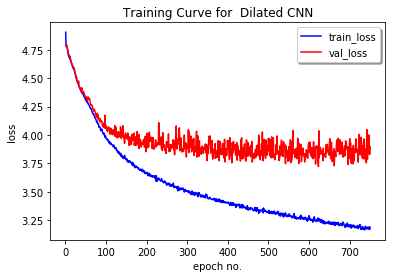

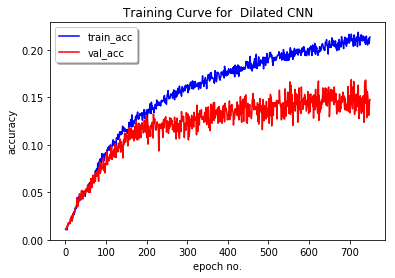

In [19]:
printGraphsFromOutput("TRAIN_LOG_DCNN_20180523.txt"," Dilated CNN")

In [20]:
#load the weights of model when validation loss was lowest (checkpointed)
from keras.models import load_model
model.load_weights('DCNNWeights-623-3.7221.hdf5')

In [21]:
temp1 = model.predict(x_testingInput, batch_size=32, verbose=1)
checkAccuracy(temp1,y_testingLabel)

2045/2045 [==============================] - 3s 2ms/step
Number of samples the prediction was applied to: 2045
Number of samples for which the model correctly predicted the breed: 342
Prediction Accuracy: 0.16723716381418094


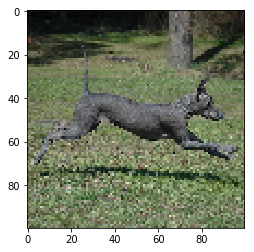

correct label: mexican_hairless
our model's prediction: irish_wolfhound
top 3: irish_wolfhound, scottish_deerhound, whippet


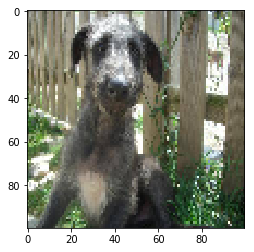

correct label: scottish_deerhound
our model's prediction: irish_wolfhound
top 3: irish_wolfhound, flat-coated_retriever, scottish_deerhound


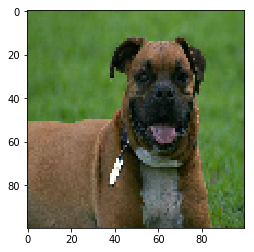

correct label: boxer
our model's prediction: leonberg
top 3: leonberg, malinois, bloodhound


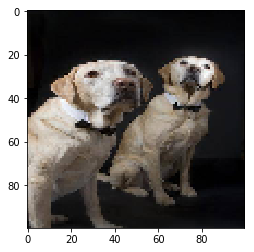

correct label: labrador_retriever
our model's prediction: english_setter
top 3: english_setter, basset, walker_hound


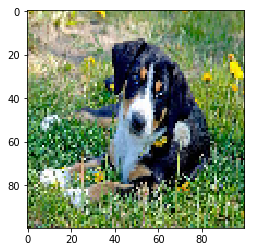

correct label: entlebucher
our model's prediction: bernese_mountain_dog
top 3: bernese_mountain_dog, appenzeller, bluetick


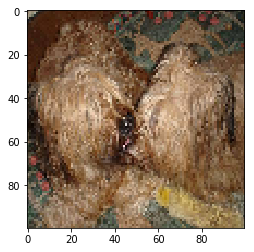

correct label: briard
our model's prediction: komondor
top 3: komondor, soft-coated_wheaten_terrier, tibetan_terrier


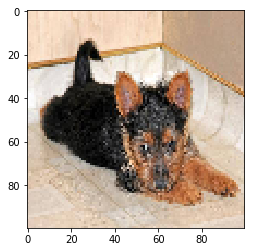

correct label: australian_terrier
our model's prediction: airedale
top 3: airedale, bloodhound, australian_terrier


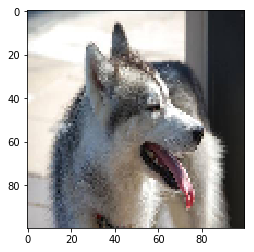

correct label: eskimo_dog
our model's prediction: japanese_spaniel
top 3: japanese_spaniel, border_collie, eskimo_dog


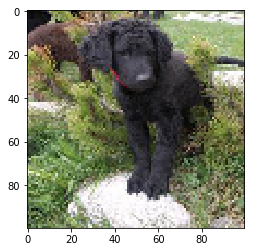

correct label: curly-coated_retriever
our model's prediction: newfoundland
top 3: newfoundland, kerry_blue_terrier, flat-coated_retriever


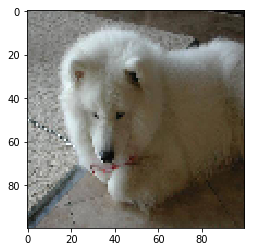

correct label: samoyed
our model's prediction: samoyed
top 3: samoyed, great_pyrenees, old_english_sheepdog


In [22]:
import heapq
#show some example picture in the testset and what the model predicted
for i in range(10):
    randPic = random.randint(0,testSize)
    plt.imshow(x_testingInput[randPic])
    plt.show()
    print("correct label: "+indices_dog[np.argmax(y_testingLabel[randPic])])
    
    rowLi = temp1[randPic].tolist()
    top3idx = heapq.nlargest(3,range(len(rowLi)),key=rowLi.__getitem__)
    
    print("our model's prediction: "+indices_dog[np.argmax(temp1[randPic])])
    print("top 3: "+indices_dog[top3idx[0]]+", "+indices_dog[top3idx[1]]+ ", "+indices_dog[top3idx[2]])

In [23]:
"""
This block saves the model as a .h5 file in the same folder this notebook is in
"""

modelfname = 'MODEL_'+ filenameDesc
dateStr = time.strftime("%d%b%y_%H%M", time.localtime())
modFName = modelfname+"_"+dateStr+'.h5'
model.save(modFName)
print("model saved at: "+time.asctime())
print("with file name: "+modFName)

model saved at: Wed May 23 00:49:48 2018
with file name: MODEL_Dilated-CNN-DataAug-Rglzr_23May18_0049.h5
